In [1]:
from timeit import default_timer as timer
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
start_time = timer()
import time

In [2]:
import calendar

# Data Quality Report

### Overview

In [3]:
data = pd.read_csv("card transactions.csv", converters={'Merchnum': lambda x:str(x)})

In [4]:
data.shape

(96753, 10)

In [5]:
data.head(5)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0


In [6]:
data.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud'],
      dtype='object')

In [7]:
data['Date'] = pd.to_datetime(data.Date, format='%Y-%m-%d')

In [8]:
data['Merch zip'] = data['Merch zip'].astype(str).str.replace('.0', '')

<ipython-input-8-27dc0256f0a6>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Merch zip'] = data['Merch zip'].astype(str).str.replace('.0', '')


In [9]:
data.dtypes

Recnum                        int64
Cardnum                       int64
Date                 datetime64[ns]
Merchnum                     object
Merch description            object
Merch state                  object
Merch zip                    object
Transtype                    object
Amount                      float64
Fraud                         int64
dtype: object

In [10]:
fsc = pd.DataFrame(index=['Cardnum', 'Merchnum', 'Merch description',
                          'Merch state', 'Merch zip', 'Transtype', 'Fraud'], 
                   columns=['% Populated','# Unique Values', 'Most Common Value'])

In [11]:
for i in fsc.index:
    fsc.loc[i,'% Populated'] = round((100 - data[i].isna().mean()*100),2)
    fsc.loc[i,'# Unique Values'] = len(data[i][data[i].notnull()].unique())
    fsc.loc[i,'Most Common Value'] = data[i].value_counts().idxmax()
fsc['# Unique Values'] = fsc.apply(lambda x: "{:,}".format(x['# Unique Values']), axis=1)
fsc

,% Populated,# Unique Values,Most Common Value
Cardnum,100.0,"1,645",5142148452
Merchnum,100.0,"13,092",930090121224
Merch description,100.0,"13,126",GSA-FSS-ADV
Merch state,98.76,227,TN
Merch zip,100.0,"2,692",38118
Transtype,100.0,4,P
Fraud,100.0,2,0


In [12]:
fsn = pd.DataFrame(index=['Date', 'Amount'], columns=['% Populated','Min','Max','Mean','Stdev','% Zero'])

In [13]:
for i in fsn.index:
    fsn.loc[i,'% Populated'] = round((100 - data[i].isna().mean()*100),2)
    fsn.loc[i,'% Zero'] = round((len(data[data[i]==0])/1000000*100),2)
    if i == 'Date':
        fsn.loc[i,'Min'] = data[i].min().strftime('%Y-%m-%d')
        fsn.loc[i,'Max'] = data[i].max().strftime('%Y-%m-%d')
        fsn.loc[i,'Mean'] = np.nan
        fsn.loc[i,'Stdev'] = np.nan
    else:
        fsn.loc[i,'Min'] = data[i].min()
        fsn.loc[i,'Max'] = "{:,}".format(data[i].max())
        fsn.loc[i,'Mean'] = "{:,}".format(round(data[i].mean(),2))
        fsn.loc[i,'Stdev'] = "{:,}".format(round(data[i].std(),2))
fsn

,% Populated,Min,Max,Mean,Stdev,% Zero
Date,100.0,2006-01-01,2006-12-31,NaN,NaN,0.0
Amount,100.0,0.01,"3,102,045.53",427.89,"10,006.14",0.0


In [14]:
data.tail(5)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
96748,96749,5142276053,2006-12-31,3500000006160,BEST BUY 00001610,KY,442,P,84.79,0
96749,96750,5142225701,2006-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248,P,118.75,0
96750,96751,5142226486,2006-12-31,4503057341100,"TECH PAC, INC",OH,451,P,363.56,0
96751,96752,5142244619,2006-12-31,8834000695412,BUY.COM,CA,92656,P,2202.03,0
96752,96753,5142243247,2006-12-31,9108347680006,STAPLES NATIONAL #471,NJ,76,P,554.64,0


In [15]:
data.count()

Recnum               96753
Cardnum              96753
Date                 96753
Merchnum             96753
Merch description    96753
Merch state          95558
Merch zip            96753
Transtype            96753
Amount               96753
Fraud                96753
dtype: int64

In [16]:
goods = data[data['Fraud'] == 0]
bads = data[data['Fraud'] == 1]
numrecords = len(data)
print(numrecords)
print(len(goods))
print(len(bads))

96753
95694
1059


In [17]:
len(data['Recnum'].unique())

96753

### Cardnum

In [18]:
plt.rcParams.update({'figure.figsize':(6,4)})
plt.rcParams.update({'font.size':10})

In [19]:
len(data['Cardnum'].unique())

1645

In [20]:
data['Cardnum'].value_counts()

5142148452    1192
5142184598     921
5142189108     663
5142297710     583
5142223373     579
              ... 
5142110002       1
5142306704       1
5142296479       1
5142246010       1
5142175806       1
Name: Cardnum, Length: 1645, dtype: int64

(400.0, 1200.0)

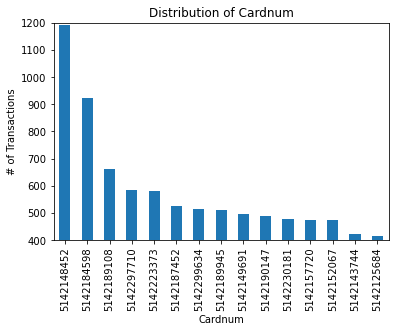

In [21]:
data['Cardnum'].value_counts().head(15).plot(kind='bar')
plt.title('Distribution of Cardnum')
plt.ylabel('# of Transactions')
plt.xlabel('Cardnum')
plt.ylim(400,1200)

### Date

In [22]:
len(data['Date'].unique())

365

In [23]:
count_day = data.groupby('Date').count()

<AxesSubplot:title={'center':'Daily Transactions'}, xlabel='Date'>

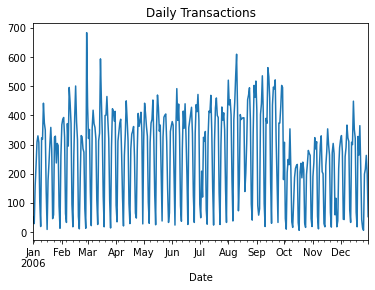

In [24]:
daily_count = data.assign(apps = np.ones(numrecords)).set_index(data['Date']).resample(dt.timedelta(days = 1))\
    .count().apps
daily_count.plot(title = 'Daily Transactions')

(800.0, 2600.0)

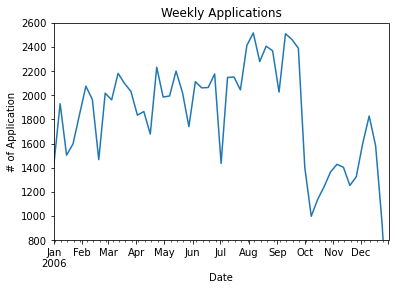

In [25]:
weekly_applications = data.assign(apps = np.ones(numrecords)).set_index(data['Date']).resample(dt.timedelta(days = 7))\
    .count().apps
weekly_applications.plot(title = 'Weekly Applications')
plt.ylabel('# of Application')
plt.xlabel('Date')
plt.xticks(rotation=0)
plt.ylim(800, 2600)

<AxesSubplot:title={'center':'Weeky Applications'}, xlabel='Date'>

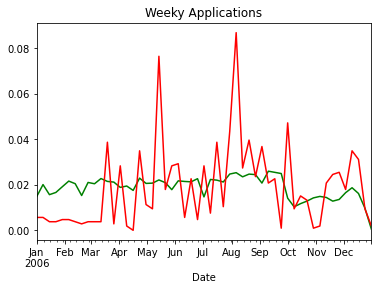

In [26]:
ngoods = len(goods)
nbads = len(bads)
goods_series = goods.assign(apps = np.ones(ngoods)).set_index(goods['Date']).resample(dt.timedelta(days = 7)).count().apps
norm_goods_series = goods_series / ngoods
norm_goods_series.plot(title = 'Weeky Applications', color = 'green')
bads_series = bads.assign(apps = np.ones(nbads)).set_index(bads['Date']).resample(dt.timedelta(days = 7)).count().apps
norm_bads_series = bads_series / nbads
norm_bads_series.plot(color = 'red')

### Merchnum

In [27]:
data['Merchnum'].value_counts()

930090121224     9310
                 3375
5509006296254    2131
9900020006406    1714
602608969534     1092
                 ... 
310400003378        1
644000797667        1
5900000003810       1
492512              1
900009088432        1
Name: Merchnum, Length: 13092, dtype: int64

In [28]:
len(data['Merchnum'].unique())

13092

In [29]:
data[data['Merchnum'] == '']

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
97,98,5142167414,2006-01-03,,CONVENIENCE CHECK FEE(%),NaN,nan,D,89.00,0
115,116,5142182128,2006-01-03,,GRAINGER #973,IL,089,P,327.34,0
135,136,5142126842,2006-01-03,,AUTOMATED OFFICE PRODU,MD,6,P,2110.00,0
163,164,5142127276,2006-01-03,,CONVENIENCE CHECK FEE(%),NaN,nan,D,4444.00,0
168,169,5142132574,2006-01-03,,ROLL CALL NEWSPAPER,DC,1,P,104.69,0
...,...,...,...,...,...,...,...,...,...,...
96621,96622,5142253938,2006-12-30,,OREGON ENVIRONMENTAL COUN,OR,974,P,40.00,0
96651,96652,5142151962,2006-12-30,,RETAIL DEBIT ADJUSTMENT,NaN,nan,P,125.00,0
96689,96690,5142166019,2006-12-30,,ADVANCED SEC & CONTROL,GA,3,P,70.50,0
96720,96721,5142178272,2006-12-31,,TRULOGIC SYSTEMS,ON,nan,P,343.42,0


Text(0.5, 0, 'Merchnum')

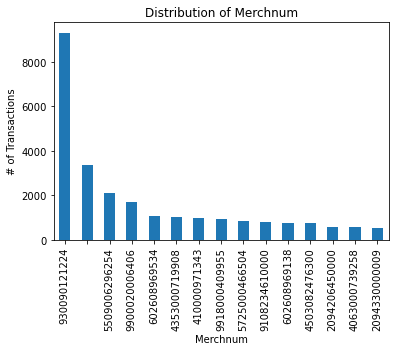

In [30]:
data['Merchnum'].value_counts().head(15).plot(kind='bar')
plt.title('Distribution of Merchnum')
plt.ylabel('# of Transactions')
plt.xlabel('Merchnum')

### Merch description

In [31]:
data['Merch description'].value_counts()

GSA-FSS-ADV               1688
SIGMA-ALDRICH             1635
STAPLES #941              1174
FISHER SCI ATL            1093
MWI*MICRO WAREHOUSE        958
                          ... 
STOP & SHOP #718             1
BIODEX MEDICAL SYSTEMS       1
ANN ARBOR PAINTERS           1
THE CONFERENCE MANAGER       1
OFFICE FURNITURE-USA         1
Name: Merch description, Length: 13126, dtype: int64

In [32]:
len(data['Merch description'].unique())

13126

(400.0, 1700.0)

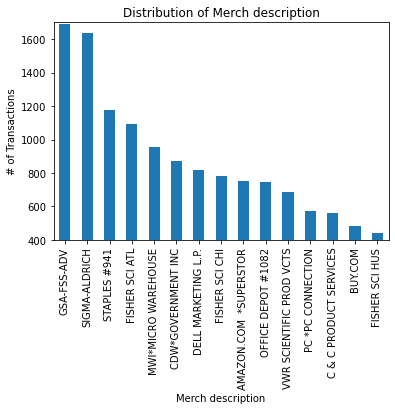

In [33]:
data['Merch description'].value_counts().head(15).plot(kind='bar')
plt.title('Distribution of Merch description')
plt.ylabel('# of Transactions')
plt.xlabel('Merch description')
plt.ylim(400, 1700)

### Merch state

In [34]:
data['Merch state'].value_counts()

TN     12035
VA      7872
CA      6817
IL      6508
MD      5398
       ...  
865        1
349        1
705        1
737        1
387        1
Name: Merch state, Length: 227, dtype: int64

In [35]:
len(data['Merch state'].unique())

228

Text(0.5, 0, 'Merch state')

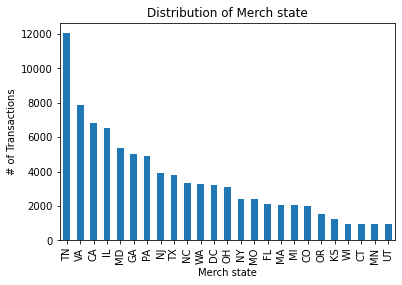

In [36]:
data['Merch state'].value_counts().head(25).plot(kind='bar')
plt.title('Distribution of Merch state')
plt.ylabel('# of Transactions')
plt.xlabel('Merch state')

### Merch zip

In [37]:
data['Merch zip'].value_counts()

38118    11868
nan       4656
6         1730
633       1661
1         1329
         ...  
19363        1
98373        1
39441        1
768          1
33415        1
Name: Merch zip, Length: 2692, dtype: int64

In [38]:
len(data['Merch zip'].unique())

2692

Text(0.5, 0, 'Merch zip')

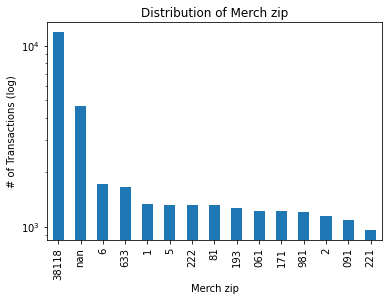

In [39]:
data['Merch zip'].value_counts().head(15).plot(kind='bar', logy=True)
plt.title('Distribution of Merch zip')
plt.ylabel('# of Transactions (log)')
plt.xlabel('Merch zip')

### Transtype

In [40]:
data['Transtype'].value_counts()

P    96398
A      181
D      173
Y        1
Name: Transtype, dtype: int64

(array([0, 1, 2, 3]),
 [Text(0, 0, 'P'), Text(1, 0, 'A'), Text(2, 0, 'D'), Text(3, 0, 'Y')])

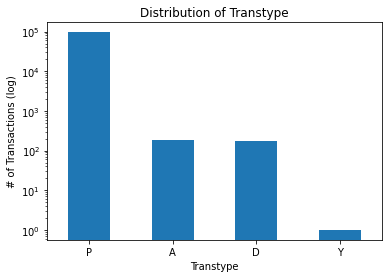

In [41]:
data['Transtype'].value_counts().plot(kind='bar', logy=True)
plt.title('Distribution of Transtype')
plt.ylabel('# of Transactions (log)')
plt.xlabel('Transtype')
plt.xticks(rotation=0)

### Amount

In [42]:
data['Amount'].describe()

count    9.675300e+04
mean     4.278857e+02
std      1.000614e+04
min      1.000000e-02
25%      3.348000e+01
50%      1.379800e+02
75%      4.282000e+02
max      3.102046e+06
Name: Amount, dtype: float64

C:\Users\Catherine\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Amount')

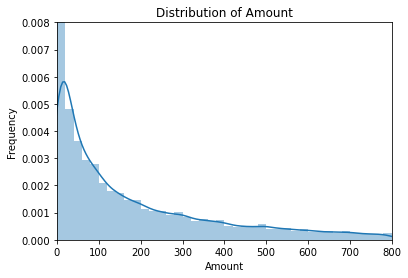

In [44]:
xhigh = 800
plt.xlim(0, xhigh)
plt.ylim(0, 0.008)
temp = data[data['Amount'] <= xhigh]
sns.distplot(temp['Amount'], bins=40, kde=True)
plt.title('Distribution of Amount')
plt.ylabel('Frequency')
plt.xlabel('Amount')